### 여러분들은 자금을 받아 펀드를 운용하는 펀드매니저입니다. 어느날, 한 고객이 찾아와 돈을 맡기면서 다음의 조건에 맞는 포트폴리오를 구성해달라고 합니다. 이를 바탕으로 다음의 질문에 답하시오.

- 다음의 주식들로 포트폴리오를 구성: 삼성전자, 엔씨소프트, SK하이닉스, 카카오, 네이버
- 2019.1.1 ~ 2020.1.1의 일별데이터를 사용.
- 수익률은 ${P_t - P_{t-1}}\over{P_{t-1}}$로 구함. 이때, $t$는 daily frequency를 의미함.
- 위험자산 중 60%는 삼성전자 주식으로 구성(무위험자산은 고려 x).
- 포트폴리오에 포함되는 모든 자산의 가중치는 0 ~ 100% 사이.
- 위험 한 단위 대비 기대수익률이 가장 높은 포트폴리오를 구성.

1. 삼성전자의 가중치는 60%로 고정하고, 나머지 가중치들을 무작위로 부여한 random portfolio를 5,000개 생성해 위험자산들로만 이루어진 mean-variance frontier를 도출하시오.

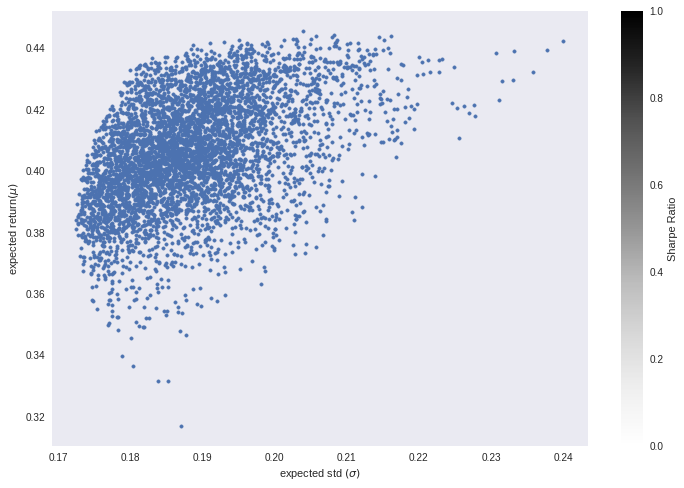

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web
import datetime

def ret_std(weight, ret) :
    port_mean = np.sum(weight * ret.mean() * 250)
    port_var = np.dot(weight.T, np.dot(ret.cov() * 250, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

port_rets = []
port_std = []
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)
data = pd.DataFrame()

for code in ['005930', '036570', '000660', '035720', '035420'] :
    data = pd.concat([data, web.DataReader(code, 'naver', start, end)['Close'].apply(int)], axis = 1)

data.columns = ['se', 'ncs', 'skh', 'kk', 'nvr']
noa = len(data.columns)
ret = data.pct_change().dropna()

for i in range(5000) :
    rweight = np.random.random(4)
    rweight /= sum(rweight)
    rweight *= 0.4
    weight = np.array([0.6])
    weight = np.append(weight, rweight)
    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets) / np.array(port_std)

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, marker='.',  cmap='RdGy')
plt.colorbar(label='Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid()



2. Risk-free rate이 0.02 일때, 무위험자산까지 포함한 mean-variance frontier를 도출하고 최적 포트폴리오의 annualized sharpe-ratio를 구하시오 (1년을 252일로 계산).

In [3]:
import scipy.optimize as opt

def statistics(weight, rf = 0.02):
    weight = np.array(weight)
    pret = np.sum(ret.mean() * weight) * 252 - rf # 
    pvol = np.sqrt(np.dot(weight.T, np.dot(ret.cov() * 252, weight)))
    return np.array([pret, pvol, pret / pvol]) #기대수익률, 분산, Sharpe Ratio

def min_func_sharpe(weight, rf = 0.02):
    return -statistics(weight, rf)[2]

def min_func_volatility(weights):
    return statistics(weights)[1] ** 2

cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})
bnds = tuple([(0.6, 0.6 + 1e-100) ] + [(0, 0.4) for x in range(noa-1)])

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method = 'SLSQP', 
                    bounds = bnds, constraints = cons)

rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x * slope + rf for x in np.linspace(0.17, 0.24, 5000)]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                    bounds=bnds, constraints=cons)

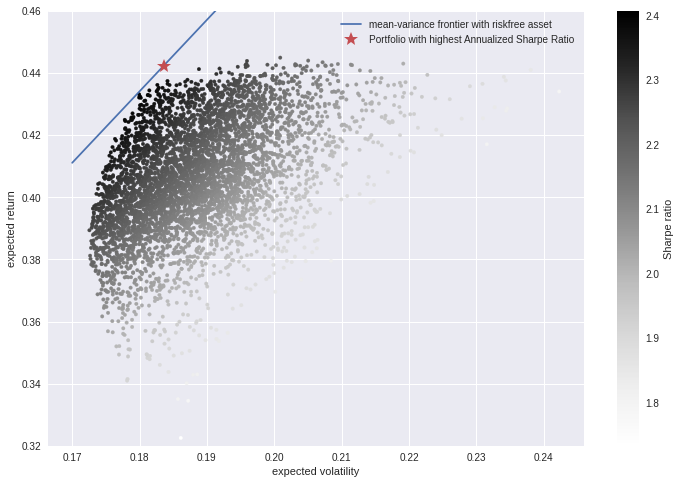

In [ ]:
x = np.linspace(0.17, 0.24, 5000)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets, c = np.array(port_rets) / np.array(port_std), marker='.')
plt.plot(x, y, label = 'mean-variance frontier with riskfree asset')


plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Annualized Sharpe Ratio')
            # portfolio with highest Sharpe ratio
        
plt.ylim((0.32, 0.46))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [ ]:
optimized_sr = statistics(opts['x'])[1] / statistics(opts['x'])[0]
print("최적 포트폴리오의 Annualized Sharpe Ratio는 ", optimized_sr.round(3))



최적 포트폴리오의 Annualized Sharpe Ratio는  0.415


3. 위의 분석들을, 이번에는 '위험자산 중 60%는 삼성전자 주식으로 구성'이라는 조건을 제외하고 다시 진행하고 새로 구한 최적 포트폴리오의 annualized sharpe-ratio를 (3-2)의 것과 비교하시오. 펀드매니저로써 고객에게 어떤 포트폴리오를 추천하겠습니까?

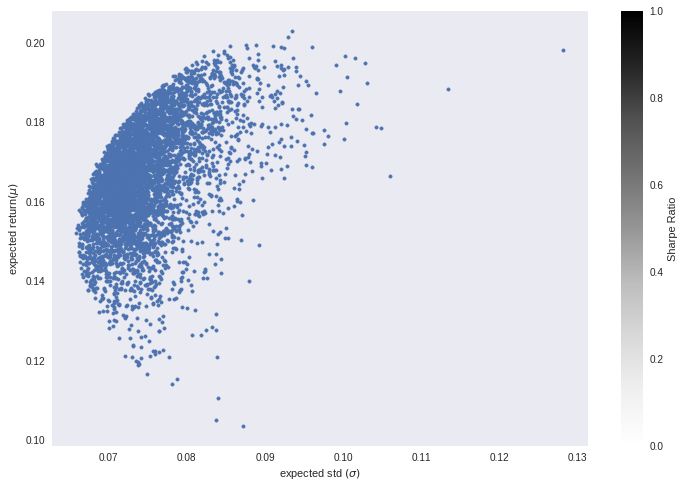

In [ ]:
port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *250)
    port_var = np.dot(weight.T, np.dot(ret.cov()*250, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for i in range(5000) :
    weight = np.random.random(5)
    weight /= sum(weight)
    weight *= 0.4
    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets) / np.array(port_std)

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, marker='.',  cmap='RdGy')
plt.colorbar(label='Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid()

In [ ]:
def statistics(weight, rf = 0.02):
    weight = np.array(weight)
    pret = np.sum(ret.mean() * weight) * 252 - rf
    pvol = np.sqrt(np.dot(weight.T, np.dot(ret.cov() * 252, weight)))
    return np.array([pret, pvol, pret / pvol]) #기대수익률, 분산, Sharpe Ratio

def min_func_sharpe(weight, rf = 0.02):
    return -statistics(weight, rf)[2]

cons1 = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})
bnds1 = tuple((0, 1) for x in range(noa))

opts1 = opt.minimize(min_func_sharpe, noa * [1. / noa,], method = 'SLSQP', 
                    bounds = bnds1, constraints = cons1)

opts1

     fun: -2.4095158849543576
     jac: array([-0.10904488, -0.0918324 , -0.10905808, -0.10881865, -0.10886803])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.34073911, 0.        , 0.10693163, 0.2997556 , 0.25257366])

In [ ]:
def min_func_port(weight):
    return statistics(weight)[1]

cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weight)

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)
tvols

array([0.26772656, 0.26772656, 0.26772656, 0.26772656, 0.26772656,
       0.26772656, 0.26772656, 0.26772656, 0.26772656, 0.26772656,
       0.26772656, 0.26772656, 0.26772656, 0.26772656, 0.26772656,
       0.26772656, 0.26772656, 0.26772656, 0.26772656, 0.26772656,
       0.26772656, 0.26772656, 0.26772656, 0.26772656, 0.26772656,
       0.26772656, 0.26772656, 0.26772656, 0.26772656, 0.26772656,
       0.26772656, 0.26772656, 0.26772656, 0.26606857, 0.26072665,
       0.25550275, 0.25040424, 0.24543894, 0.2406151 , 0.23594139,
       0.23142692, 0.22708117, 0.22291402, 0.21893567, 0.21515613,
       0.21152418, 0.20800425, 0.20460212, 0.20132376, 0.19817531])

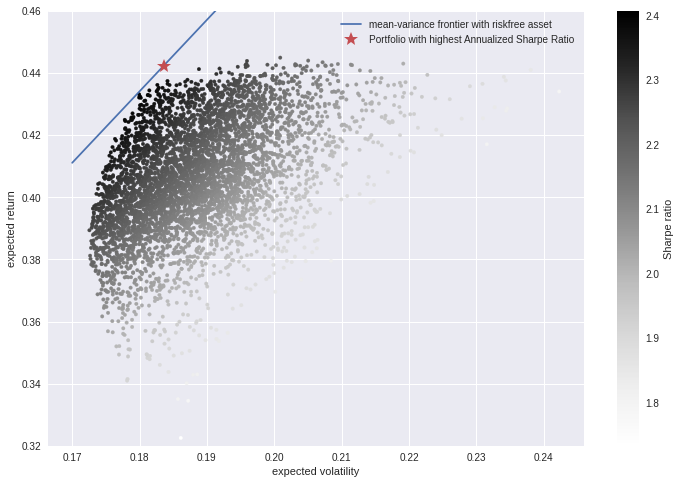

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')
            # random portfolio composition

plt.plot(x, y, label = 'mean-variance frontier with riskfree asset')
plt.plot(statistics(opts1['x'])[1], statistics(opts1['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Annualized Sharpe Ratio')
            # portfolio with highest Sharpe ratio
plt.ylim((0.32, 0.46))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')   

In [ ]:
opt_sr = statistics(opts1['x'])[1] / statistics(opts1['x'])[0]
print(opt_sr.round(3))

0.415



두 포트폴리오의 Sharpe Ratio가 무차별하므로 삼성전자를 선호하는 투자자에게는 삼전 60%의 포트폴리오를, 그렇지 않을 경우 위 포트폴리오를 제시한다.